In [1]:
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date


# sklearn tools from model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

In [2]:
import lightgbm as lgb
from collections import Counter

In [3]:
#load all datasets
data_path='/Users/fengxiao/Documents/Johns Hopkins MS Data Science/2017 Fall/Udacity Machine learning/machine-learning/Machine-Learning-projects/music recommendation/data/'




train = pd.read_csv(data_path+'train.csv',dtype={'msno': 'category',
                                                 'song_id': 'category',
                                                'source_system_tab': 'category',
                                                'source_screen_name': 'category',
                                                'source_type': 'category',
                                                 'target':np.uint8
                                                })
test = pd.read_csv(data_path + 'test.csv', dtype={'msno': 'category',
                                                 'song_id': 'category',
                                                'source_system_tab': 'category',
                                                'source_screen_name': 'category',
                                                'source_type': 'category'})
songs = pd.read_csv(data_path + 'songs.csv', dtype={'song_id': 'category',
                                                   'genre_ids': 'category',
                                                    'language': 'category',
                                                    'composer': 'category',
                                                    'lyricist': 'category',
                                                    'artist_name': 'category',
                                                    'song_length':np.int32
                                                   })
songE = pd.read_csv(data_path + 'song_extra_info.csv')
members = pd.read_csv(data_path + 'members.csv',dtype={'city':'category',
                                                      'bd':np.uint8,
                                                      'gender': 'category',
                                                      'registered_via': 'category'},parse_dates=['registration_init_time','expiration_date'])
recommend_artist = pd.read_csv(data_path+'recommend_artists.csv', dtype={'recom_artist1':'category',
                                                                        'recom_artist2':'category',
                                                                        'recom_artist3':'category'})


In [46]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


## songs extra info

In [4]:
#extract year information of song from isrc use https://www.kaggle.com/kamilkk/i-have-to-say-this

def isrc_to_year(isrc):
    if type(isrc) == str:
        
        if int(isrc[5:7]) > 17:
            return str(1900 + int(isrc[5:7]))
        else:
            return str(2000 + int(isrc[5:7]))
    else:
        return np.nan
    
songE['song_year'] = songE['isrc'].apply(isrc_to_year).astype('category')
   
    

In [5]:
songE.drop(['isrc','name'], axis = 1, inplace = True)

In [6]:
# join song_year info to train and test
train = train.merge(songE, on='song_id', how='left')
test = test.merge(songE, on = 'song_id', how='left')

## train and test data is chronologically ordered
https://www.kaggle.com/kamilkk/i-have-to-say-this 

In [126]:
train.song_year.dtype

category

In [129]:
## count the fraction of songs was released in 2017
train['2017_songs_frac']=(train['song_year']=='2017').rolling(window=50000, center=True).mean()
test['2017_songs_frac']=(test['song_year']=='2017').rolling(window=5000,center=True).mean()

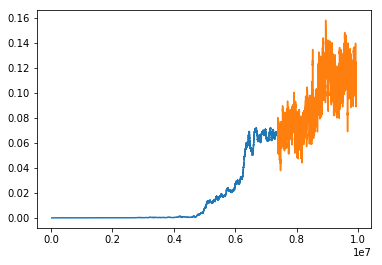

In [130]:
plt.figure()
plt.plot(train.index.values, train['2017_songs_frac'],'-', train.shape[0]+test.index.values, test['2017_songs_frac'],'-')

### conclusion: train and test data sets are in chronologically ordered
train data validation use last 2.5 milion records

## members

In [7]:
members['membership_duration'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)


members['regis_year'] = members['registration_init_time'].dt.year
members['regis_month'] = members['registration_init_time'].dt.month
members['regis_day'] = members['registration_init_time'].dt.day

members['expir_year'] = members['expiration_date'].dt.year
members['expir_month'] = members['expiration_date'].dt.month
members['expir_day'] = members['expiration_date'].dt.day

In [8]:
members.drop(['registration_init_time','expiration_date'],axis=1, inplace =True)

In [9]:
train=train.merge(members, on='msno',how='left')
test = test.merge(members, on='msno', how='left')

## Songs

In [10]:
def multi_count(x):
    if x is None:
        return 0
    else:
        return sum(map(x.count,['|','/','\\',';','and','feat','&',',','、'])) + 1

In [11]:
songs['genre_ids_count'] = songs['genre_ids'].apply(multi_count).astype(np.int32)
songs['artist_name_count'] = songs['artist_name'].apply(multi_count).astype(np.int32)
songs['composer_count'] = songs['composer'].apply(multi_count).astype(np.int32)
songs['lyricist_count'] = songs['lyricist'].apply(multi_count).astype(np.int32)

In [12]:
songs['artist_composer'] = (songs['artist_name'].astype('object')==songs['composer'].astype('object')).astype('category')
songs['artist_lyricist'] = (songs['artist_name'].astype('object')==songs['lyricist'].astype('object')).astype('category')
songs['artist_composer_lyricist'] = ((songs['artist_name'].astype('object')==songs['composer'].astype('object'))
                                     &(songs['artist_name'].astype('object')==songs['lyricist'].astype('object'))
                                    &(songs['lyricist'].astype('object')==songs['composer'].astype('object'))).astype('category')

In [13]:
# merge with train/test
train = train.merge(songs, on ='song_id', how='left')
test = test.merge(songs, on='song_id', how = 'left')

## recommend_artist

In [14]:
recommend_artist.head()

,Unnamed: 0,msno,recom_artist1,recom_artist2,recom_artist3
0,0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,韋禮安 (William Wei),李榮浩,楊丞琳 (Rainie Yang)
1,1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),A-Lin,謝和弦 (R-chord)
2,2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,韋禮安 (William Wei),A-Lin,李榮浩
3,3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,丁噹 (Della),aMEI (張惠妹),郭靜 (Claire Kuo)
4,4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,李榮浩,aMEI (張惠妹),林宥嘉 (Yoga Lin)


In [15]:
train=train.merge(recommend_artist[['msno','recom_artist1','recom_artist2','recom_artist3']], on='msno', how='left')
test=test.merge(recommend_artist[['msno','recom_artist1','recom_artist2','recom_artist3']], on='msno', how='left')

## Check null value in train

In [106]:
train.isnull().sum(axis=0)

msno                         0
song_id                      0
source_system_tab        18371
source_screen_name      414804
source_type              21539
target                       0
song_year               577858
city                         0
bd                           0
gender                 2961479
registered_via               0
membership_duration          0
regis_year                   0
regis_month                  0
regis_day                    0
expir_year                   0
expir_month                  0
expir_day                    0
song_length                114
genre_ids               118455
artist_name                114
composer               1675706
lyricist               3178797
language                   150
dtype: int64

In [12]:
#the list of columns contain missing value
columns = train.isnull().sum(axis=0)

In [13]:
columns_null = columns.loc[columns >0].index.tolist()
print (columns_null)

['source_system_tab', 'source_screen_name', 'source_type', 'song_year', 'gender', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']


In [24]:
## get column data type
train[columns_null].dtypes

source_system_tab     category
source_screen_name    category
source_type           category
song_year             category
gender                category
genre_ids             category
artist_name           category
composer              category
lyricist              category
language              category
dtype: object

In [15]:
# fill missing song length with median
train.song_length.fillna(value=train['song_length'].median(), inplace=True)
columns_null.remove('song_length')

In [114]:
columns_null

['source_system_tab',
 'source_screen_name',
 'source_type',
 'song_year',
 'gender',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language']

In [17]:
# fill missing category with unknown .cat.add_categories(['unknown'])
for col in columns_null:
    train[col] = train[col].astype('object')
    train[col].fillna(value='unknown', inplace=True)
    train[col] = train[col].astype('category')


In [18]:
train.isnull().any()

msno                   False
song_id                False
source_system_tab      False
source_screen_name     False
source_type            False
target                 False
song_year              False
city                   False
bd                     False
gender                 False
registered_via         False
membership_duration    False
regis_year             False
regis_month            False
regis_day              False
expir_year             False
expir_month            False
expir_day              False
song_length            False
genre_ids              False
artist_name            False
composer               False
lyricist               False
language               False
dtype: bool

In [11]:
train.shape

(7377418, 24)

In [14]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_year', 'city', 'bd', 'gender',
       'registered_via', 'membership_duration', 'regis_year', 'regis_month',
       'regis_day', 'expir_year', 'expir_month', 'expir_day', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

## Check null value in train

In [130]:
test.isnull().sum(axis=0)

id                           0
msno                         0
song_id                      0
source_system_tab         5096
source_screen_name      162883
source_type               7297
song_year               196643
city                         0
bd                           0
gender                 1052224
registered_via               0
membership_duration          0
regis_year                   0
regis_month                  0
regis_day                    0
expir_year                   0
expir_month                  0
expir_day                    0
song_length                 25
genre_ids                42110
artist_name                 25
composer                619304
lyricist               1224744
language                    42
genre_ids_count              0
lyricists_count              0
composer_count               0
dtype: int64

In [19]:
#the list of columns contain missing value
columns = test.isnull().sum(axis=0)

In [20]:
columns_null = columns.loc[columns >0].index.tolist()
print (columns_null)

['source_system_tab', 'source_screen_name', 'source_type', 'song_year', 'gender', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']


In [21]:
## get column data type
test[columns_null].dtypes

source_system_tab     category
source_screen_name    category
source_type           category
song_year             category
gender                category
song_length            float64
genre_ids             category
artist_name           category
composer              category
lyricist              category
language              category
dtype: object

In [22]:
# fill missing song length with median
test.song_length.fillna(value=test['song_length'].median(), inplace=True)
columns_null.remove('song_length')

In [23]:
# fill missing category with unknown 
for col in columns_null:
    test[col] = test[col].astype('object')
    test[col].fillna(value='unknown', inplace=True)
    test[col] = test[col].astype('category')


In [140]:
test.isnull().any()

id                     False
msno                   False
song_id                False
source_system_tab      False
source_screen_name     False
source_type            False
song_year              False
city                   False
bd                     False
gender                 False
registered_via         False
membership_duration    False
regis_year             False
regis_month            False
regis_day              False
expir_year             False
expir_month            False
expir_day              False
song_length            False
genre_ids              False
artist_name            False
composer               False
lyricist               False
language               False
genre_ids_count        False
lyricists_count        False
composer_count         False
dtype: bool

## additional variables 

## songs, genre, artist and language popularity

In [17]:
train['genre_ids'].head()

0     359
1    1259
2    1259
3    1019
4    1011
Name: genre_ids, dtype: category
Categories (1045, object): [1007, 1011, 1011|2189|367, 1011|691, ..., 1609|437, 1969|940|2100, 786|958|2022, 873|1609]

In [16]:
popularity_features =['song_id','genre_ids','artist_name','composer']
for feat in popularity_features:
    train['popularity_'+feat]= train[feat].map(Counter(train[feat])).astype(np.int64)
    test['popularity_'+feat] = test[feat].map(Counter(test[feat])).astype(np.int64)
    

### person-artist, lyricist, genre, composer 

In [16]:
person_liked=['artist_name','genre_ids','composer','lyricist']
for i in person_liked:
    agg=pd.DataFrame(train.groupby(['msno',i])['target'].sum()).reset_index(level=['msno',i])
    agg.rename(columns={'target':'person_'+i},inplace=True)
    train = train.merge(agg, on=['msno',i], how= 'left')
    test = test.merge(agg, on=['msno',i], how= 'left')


In [17]:

test.shape

(2556790, 39)

In [18]:
train.shape

(7377418, 39)

### experient on variables

In [32]:
droplist=['popularity_language']
train= train.drop(droplist,axis=1)
test = test.drop(droplist, axis=1)

In [17]:
train.head().T

,0,1,2,3,4
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=
source_system_tab,explore,my library,my library,my library,explore
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more,Explore
source_type,online-playlist,local-playlist,local-playlist,local-playlist,online-playlist
target,1,1,1,1,1
song_year,2016,1999,2006,2010,2016
city,1,13,13,13,1
bd,0,24,24,24,0
gender,NaN,female,female,female,NaN


In [31]:
train.drop(['person_genre_ids','person_composer','person_lyricist'],axis=1, inplace =True)
test.drop(['person_genre_ids','person_composer','person_lyricist'],axis=1, inplace =True)

## model development

## split train/validation sets

In [18]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [19]:
X= train.drop(['target'],axis=1)
y = train.target

In [20]:
## becuase train dataset is in chronologically ordered
X_train = X.iloc[:X.shape[0]-2500000,:]
X_val = X.iloc[X.shape[0]-2500000:X.shape[0]+1,:]

In [21]:
y_train = y.iloc[:y.shape[0]-2500000,]
y_val = y.iloc[y.shape[0]-2500000:y.shape[0]+1,]

## lightGBM model

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)


In [23]:
lgb_all = lgb.Dataset(X,y)


In [24]:
params = {
    'objective':'binary',
    'boosting': 'dart',
    'learning_rate':0.2, 
          'application':'binary', 
          'max_depth':30, 
          'num_leaves':108,
          'verbosity':0,
          'metric':'auc',
         'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10}

In [26]:
%time model = lgb.train(params,train_set = lgb_all,num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=5, verbose_eval=5)

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's auc: 0.687445
[10]	valid_0's auc: 0.697399
[15]	valid_0's auc: 0.703872
[20]	valid_0's auc: 0.710547
[25]	valid_0's auc: 0.714834
[30]	valid_0's auc: 0.71704
[35]	valid_0's auc: 0.71873
[40]	valid_0's auc: 0.722031
[45]	valid_0's auc: 0.723712
[50]	valid_0's auc: 0.725158
[55]	valid_0's auc: 0.727033
[60]	valid_0's auc: 0.728332
[65]	valid_0's auc: 0.729827
[70]	valid_0's auc: 0.73153
[75]	valid_0's auc: 0.73265
[80]	valid_0's auc: 0.733588
[85]	valid_0's auc: 0.733609
[90]	valid_0's auc: 0.734228
[95]	valid_0's auc: 0.735223
[100]	valid_0's auc: 0.736728
CPU times: user 30min 23s, sys: 1min 4s, total: 31min 28s
Wall time: 4min 42s


###### grid search lightGBM

In [115]:
gridParams ={'boosting': ['gbdt','dart'],
            'learning_rate': [0.2,0.3,0.5]
            }

In [117]:
mdl = lgb.LGBMClassifier('objective': 'binary',
        'metric': 'binary_logloss',
       
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 200)
mdl.get_params().keys()

dict_keys(['boosting_type', 'colsample_bytree', 'learning_rate', 'max_bin', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

## implement model on test dataset

In [27]:
X_test = test.drop(['id'],axis=1)
ids = test.id

In [28]:
p_test = model.predict(X_test)

In [29]:
submission = pd.DataFrame()
submission['id']=ids
submission['target'] = p_test

In [30]:
submission.to_csv(data_path+'submission8.csv.gz',compression ='gzip',index=False, float_format ='%.5f')

In [104]:
X.columns

Index(['source_system_tab', 'source_screen_name', 'source_type', 'song_year',
       'city', 'bd', 'gender', 'registered_via', 'regis_year', 'regis_month',
       'regis_day', 'expir_year', 'expir_month', 'expir_day', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')

In [47]:
submission.head()

,id,target
0,0,0.580721
1,1,0.669864
2,2,0.148302
3,3,0.106231
4,4,0.165245
